# Suppress gibbs artefact in DWI

In this notebook, I am testing an algorithm to suppress Gibbs artefact oscillations.
This algorithm is an adaption of a procedure suggested by:

[Kellner et al. Gibbs‐ringing artifact removal based on local subvoxel‐shifts (2016). Magn Reson Med 76:1574–1581](https://doi.org/10.1002/mrm.26054)

The full adapted version of algorithm is described in the chapter 3 of my PhD thesis:

[Neto Henriques, R. (2018). Advanced Methods for Diffusion MRI Data Analysis and their Application to the Healthy Ageing Brain (Doctoral thesis). https://doi.org/10.17863/CAM.29356](https://www.repository.cam.ac.uk/handle/1810/281993)

If you use this code, please cite the two references pointed above.


So let's start importing the relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dipy.data import fetch_tissue_data, read_tissue_data
from gibbs_removal import gibbs_removal

Just to check that everything is in order, let's first run the Gibbs unringing on a simple simulated phantom.

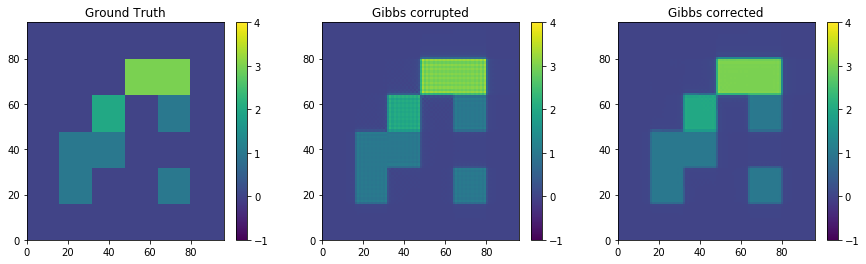

In [2]:
# Produce phantom
Nori = 32
image = np.zeros((6*Nori, 6*Nori))
image[Nori:2*Nori, Nori:2*Nori] = 1
image[Nori:2*Nori, 4*Nori:5*Nori] = 1
image[2*Nori:3*Nori, Nori:3*Nori] = 1
image[3*Nori:4*Nori, 2*Nori:3*Nori] = 2
image[3*Nori:4*Nori, 4*Nori:5*Nori] = 1
image[4*Nori:5*Nori, 3*Nori:5*Nori] = 3
c = np.fft.fft2(image)
c = np.fft.fftshift(c)
N = c.shape[0]
c_crop = c[48: 144, 48: 144]
N = c_crop.shape[0]
image_gibbs = abs(np.fft.ifft2(c_crop)/4)

# Produce ground truth
Nre = 16
image_gt = np.zeros((6*Nre, 6*Nre))
image_gt[Nre:2*Nre, Nre:2*Nre] = 1
image_gt[Nre:2*Nre, 4*Nre:5*Nre] = 1
image_gt[2*Nre:3*Nre, Nre:3*Nre] = 1
image_gt[3*Nre:4*Nre, 2*Nre:3*Nre] = 2
image_gt[3*Nre:4*Nre, 4*Nre:5*Nre] = 1
image_gt[4*Nre:5*Nre, 3*Nre:5*Nre] = 3

# Correct gibbs
image_cor = gibbs_removal(image_gibbs)

# plot
fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 3, 1)
plt.pcolormesh(image_gt, cmap='viridis', vmin=-1, vmax=4)
plt.axis([0, 96, 0, 96])
plt.colorbar()
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.pcolormesh(image_gibbs, cmap='viridis', vmin=-1, vmax=4)
plt.axis([0, 96, 0, 96])
plt.colorbar()
plt.title('Gibbs corrupted')

plt.subplot(1, 3, 3)
plt.pcolormesh(image_cor, cmap='viridis', vmin=-1, vmax=4)
plt.axis([0, 96, 0, 96])
plt.colorbar()
plt.title('Gibbs corrected')

plt.show()

The synthetic ground truth phantom is plotted in the left panel. This phantom consists of blocks of uniform intensities. To generate Gibbs artefacts, the high frequencies of the phantom's Fourier transform are removed (middle image panel). The data corrected from Gibbs artefacts is shown in the right panel. Although the Gibb's suppression algorithm cannot recover the smoothed image edge this seems to successfully suppress the artefactual intensity oscillations.

Now let’s apply to an in-vivo MRI experiment, that can be downloaded using Dipy command lines.

In [3]:
fetch_tissue_data()

t1_img = read_tissue_data(contrast='T1 denoised')

t1 = t1_img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/rafael/.dipy/tissue_data 


Let's plot an image slice.

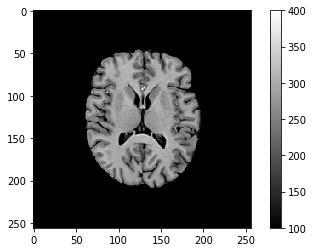

In [4]:
axial_slice = 88
t1_slice = t1[..., axial_slice]

fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(wspace=0.2)

t1_slice = np.rot90(t1_slice)

plt.subplot(1, 2, 1)
plt.imshow(t1_slice, cmap='gray', vmin=100, vmax=400)
plt.colorbar()

Due to the high quality of the data, Gibbs artefacts are not visually evident in this dataset. Therefore, to analyse the benefits of the Gibbs suppression, Gibbs artefacts are artificially introduced by removing high frequencies of the image's Fourier transform.

In [5]:
c = np.fft.fft2(t1_slice)
c = np.fft.fftshift(c)
N = c.shape[0]
c_crop = c[64: 192, 64: 192]
N = c_crop.shape[0]
t1_gibbs = abs(np.fft.ifft2(c_crop)/4)

Let’s apply the Gibbs removal algorithm and plot the data:

Text(30, 0, 'Rings')

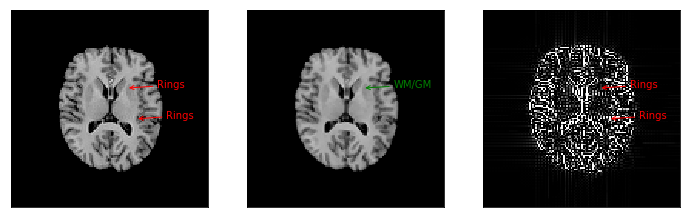

In [6]:
t1_unring = gibbs_removal(t1_gibbs)

fig1, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
ax.flat[0].imshow(t1_gibbs, cmap="gray", vmin=100, vmax=400)
ax.flat[0].annotate('Rings', fontsize=10, xy=(81, 70),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", 
                                    color = 'red')
             )
ax.flat[0].annotate('Rings', fontsize=10, xy=(75, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", 
                                    color = 'red')
             )

ax.flat[1].imshow(t1_unring, cmap="gray", vmin=100, vmax=400)
ax.flat[1].annotate('WM/GM', fontsize=10, xy=(75, 50),
                    color='green',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", 
                                    color = 'green')
             )

ax.flat[2].imshow(t1_unring - t1_gibbs, cmap="gray", vmin=0, vmax=10)
ax.flat[2].annotate('Rings', fontsize=10, xy=(81, 70),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", 
                                    color = 'red')
             )
ax.flat[2].annotate('Rings', fontsize=10, xy=(75, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", 
                                    color = 'red')
             )


In the left panel, the image artificially corrupted with Gibb's artefacts present the characteristic ringing profiles (examples pointed by the red arrows). In the middle panel, these artefactual oscillations seem to be visually suppressed without compromising the contrast between white and grey matter. The difference between uncorrected and corrected data is plotted in the right panel, highlighting the suppressed Gibbs ringing profile.